In [52]:
import torch
from torch import optim
import torch.nn as nn
from torchvision import datasets, transforms
import dnnlib
import torch_utils
import pickle

from copy import deepcopy

import stylegan2.training.dorm_networks as networks

import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import numpy as np

from tqdm import tqdm
import tqdm as T
import random
tqdm.pandas()

import shutil

In [53]:
stylegan = pickle.load(open("./pretrained_stylegans/ffhq.pkl","rb"))

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [55]:
generator = stylegan['G']
G = networks.DoRMGenerator(generator.z_dim,generator.c_dim,generator.w_dim,generator.img_resolution,generator.img_channels).to(device) 
_ = G.load_state_dict(generator.state_dict(),strict = False)
D = stylegan['D'].to(device)

del generator

In [56]:
G.requires_grad_(False)
G.target_mapping.requires_grad_(True)
for x, i in G.named_modules():
    if 'target_affine' in x:
        i.requires_grad_(True)

D.requires_grad_(False)
for i in range(2,6):
    getattr(D,f'b{2**i}').requires_grad_(False)

In [57]:
LR = 1e-3
opt_g = optim.Adam([{'params': [param for name, param in G.named_parameters() if 'target_affine' in name]},
                     {'params': G.target_mapping.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_d = optim.Adam(
    D.parameters(), lr= LR, betas =(0.0, 0.99)
)

In [58]:
target_folder = "./DoRM/glassesFaces/"
im_names = None
for x in os.walk(target_folder):
    im_names = x[2]
    break

In [59]:
trainsform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((1024, 1024)),
     transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.Normalize(
        [0.5 for _ in range(3)],
        [0.5 for _ in range(3)],
     )
    ]
)

data = torch.Tensor(np.array([trainsform(torch.from_numpy(plt.imread(os.path.join(target_folder,x))).permute(2,0,1)).numpy() for x in im_names])).to(device)

In [60]:
counter = 0
total_samples = 100000
with tqdm(total=total_samples) as pbar:
    while counter < total_samples:
        target_batch = data[[random.randint(0,9) for _ in range(4)]]

        zs = torch.randn(4, G.z_dim).to(device)
        zt = torch.randn(4, G.z_dim).to(device)
        c = torch.zeros(4,G.c_dim).to(device)
        
        # generate images from both source & target domains
        gen_target = G(zs, zt, c, 1.0)
        # gen_source = G(zs, zt, c, 0.0)
        
        disc_target = nn.functional.sigmoid(D(target_batch,c))
        disc_gen = nn.functional.sigmoid(D(gen_target,c))
        # disc_source = D(gen_source.detach(),c)
        
        # Critic loss is loss for 
        loss_disc = -torch.mean(1 - disc_gen) - torch.mean(disc_target)
        # loss_disc = -torch.mean(1 - disc_gen) - torch.mean(disc_target) + torch.mean(disc_source)
        D.zero_grad()
        loss_disc.backward()
        opt_d.step()
        
        gen_target = G(zs, zt, c, 1.0)
        disc_gen = nn.functional.sigmoid(D(gen_target,c))
        
        loss_gen = -torch.mean(disc_gen)
        loss_gen.backward()
        opt_g.step()

        counter+=4
        pbar.update(4)

  0%|                                                                                                                                                                                   | 0/100000 [00:00<?, ?it/s]/common/home/aaj116/.local/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|                                                                                                                                                                        | 20/100000 [00:04<5:44:13,  4.84it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0.3121]], device='cuda:0', grad_fn=<SigmoidBackward0>)


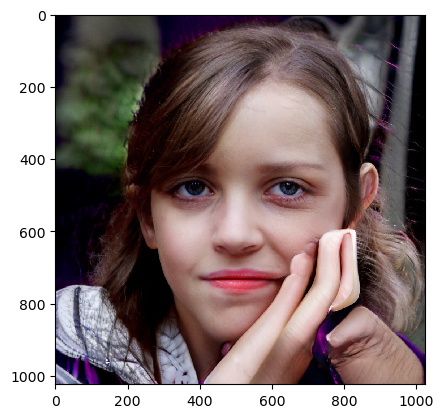

In [63]:
zs = torch.randn(1, G.z_dim).to(device)
zt = torch.randn(1, G.z_dim).to(device)
c = torch.zeros(1,G.c_dim).to(device)

# generate images from both source & target domains
gen_target = G(zs, zt, c, 0.01)

print(nn.functional.sigmoid(D(gen_target,c)))

plt.imshow((gen_target[0].permute(1,2,0).cpu().detach().numpy()+1)/2.0)

In [ ]:
torch.save(G.state_dict(),"./glasses_model")